<a href="https://colab.research.google.com/github/GlauberRuan/skin-cancer-detection-cnn/blob/main/skin_cancer_cnn_classifier_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Instalação e Importações
# !pip install kagglehub tensorflow seaborn matplotlib scikit-learn

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kagglehub
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201, ResNet50, Xception, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.metrics import confusion_matrix, classification_report

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [ ]:
# 2. Configurações e Callbacks
NUM_CLASSES = 9
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42

# Configurando sementes para reprodutibilidade
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- CALLBACK PERSONALIZADO (NOVO) ---
class OverallProgressCallback(Callback):
    def __init__(self, total_epochs, model_name):
        super().__init__()
        self.total_epochs = total_epochs
        self.model_name = model_name

    def on_epoch_end(self, epoch, logs=None):
        # verbose=2 já mostra o progresso linha a linha
        pass

In [ ]:
# 3. Download e Preparação dos Dados
print("Baixando dataset do Kaggle...")
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

# Define o diretório base (ajuste se necessário)
DATA_DIR = os.path.join(path, 'Skin cancer ISIC The International Skin Imaging Collaboration')
print(f"Dataset localizado em: {DATA_DIR}")

Baixando dataset do Kaggle...


100%|██████████| 786M/786M [00:19<00:00, 41.4MB/s]

Extracting files...


Dataset localizado em: /root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1/Skin cancer ISIC The International Skin Imaging Collaboration


In [ ]:
# 4. Data Augmentation e Geradores
train_aug = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.20 # 20% para validação
)

test_aug = ImageDataGenerator(rescale=1./255)

print("Criando geradores de imagem...")

# Otimização: Aumentando workers para carregar dados mais rápido
train_generator = train_aug.flow_from_directory(
    os.path.join(DATA_DIR, 'Train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

validation_generator = train_aug.flow_from_directory(
    os.path.join(DATA_DIR, 'Train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

test_generator = test_aug.flow_from_directory(
    os.path.join(DATA_DIR, 'Test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print(f"Classes identificadas: {class_names}")

Criando geradores de imagem...
Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Classes identificadas: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
# 5. Função de Construção do Modelo
def build_finetuned_model(base_architecture, name):
    """
    Constrói um modelo de classificação baseado em uma arquitetura pré-treinada.
    """
    # Carrega a base pré-treinada (ImageNet) sem o topo (camadas densas)
    base_model = base_architecture(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

    # Congela os pesos da base (Transfer Learning)
    base_model.trainable = False

    # Adiciona novas camadas de classificação (Top Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x) # Dropout para regularização
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Cria o modelo final
    model = Model(inputs=base_model.input, outputs=predictions, name=name)

    # Compila o modelo
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# 6. Loop de Treinamento (Todos os Modelos)
models_to_test = {
    'DenseNet201': DenseNet201,
    'ResNet50': ResNet50,
    'Xception': Xception,
    'MobileNetV2': MobileNetV2
}

results = {}

for name, base_architecture in models_to_test.items():
    print(f"\n{'='*40}")
    print(f"🚀 Iniciando treinamento: {name}")
    print(f"{'='*40}")

    # 1. Constrói o modelo
    model = build_finetuned_model(base_architecture, name)

    # 2. Define os Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
        ModelCheckpoint(f"best_model_{name}.keras", monitor="val_loss", save_best_only=True)
    ]

    # 3. Inicia o Treinamento
    # verbose=2: Modo silencioso (1 linha por época) para evitar travamentos e erros
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=callbacks,
        verbose=2
    )

    # 4. Avaliação no conjunto de Teste
    print(f"\nAvaliando {name} no conjunto de teste...")
    test_loss, test_acc = model.evaluate(test_generator, verbose=1)
    print(f"✅ Acurácia Final ({name}): {test_acc:.4f}")

    # 5. Salva histórico
    results[name] = {
        'model': model,
        'history': history.history,
        'test_acc': test_acc
    }


🚀 Iniciando treinamento: DenseNet201


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
56/56 - 156s - 3s/step - accuracy: 0.3732 - loss: 1.8501 - val_accuracy: 0.4399 - val_loss: 1.5404 - learning_rate: 1.0000e-03
Epoch 2/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


56/56 - 10s - 176ms/step - accuracy: 0.4688 - loss: 1.4506 - val_accuracy: 0.4375 - val_loss: 1.5410 - learning_rate: 1.0000e-03
Epoch 3/30
56/56 - 49s - 869ms/step - accuracy: 0.4969 - loss: 1.4495 - val_accuracy: 0.4712 - val_loss: 1.4601 - learning_rate: 1.0000e-03
Epoch 4/30
56/56 - 10s - 174ms/step - accuracy: 0.5000 - loss: 1.3691 - val_accuracy: 0.4663 - val_loss: 1.4898 - learning_rate: 1.0000e-03
Epoch 5/30
56/56 - 49s - 881ms/step - accuracy: 0.5230 - loss: 1.3595 - val_accuracy: 0.4784 - val_loss: 1.4487 - learning_rate: 1.0000e-03
Epoch 6/30
56/56 - 12s - 223ms/step - accuracy: 0.5625 - loss: 1.2326 - val_accuracy: 0.4856 - val_loss: 1.4076 - learning_rate: 1.0000e-03
Epoch 7/30
56/56 - 45s - 809ms/step - accuracy: 0.5423 - loss: 1.2886 - val_accuracy: 0.4567 - val_loss: 1.4648 - learning_rate: 1.0000e-03
Epoch 8/30
56/56 - 10s - 180ms/step - accuracy: 0.5938 - loss: 1.2283 - val_accuracy: 0.4880 - val_loss: 1.4322 - learning_rate: 1.0000e-03
Epoch 9/30
56/56 - 47s - 835ms/

✅ Detectado variável 'results' (do código original).

--- Gerando Gráficos de Performance ---


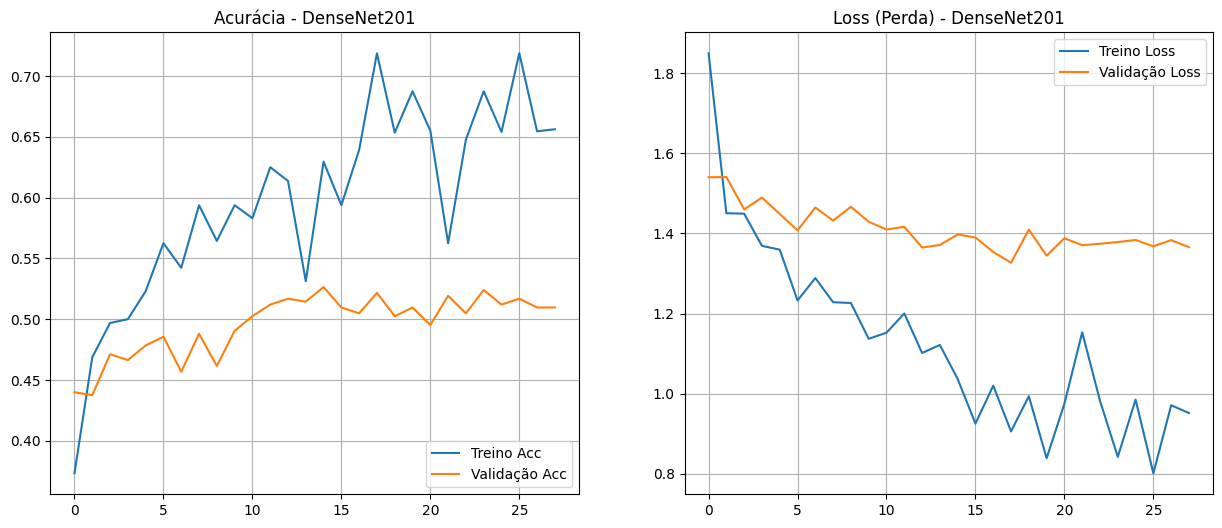

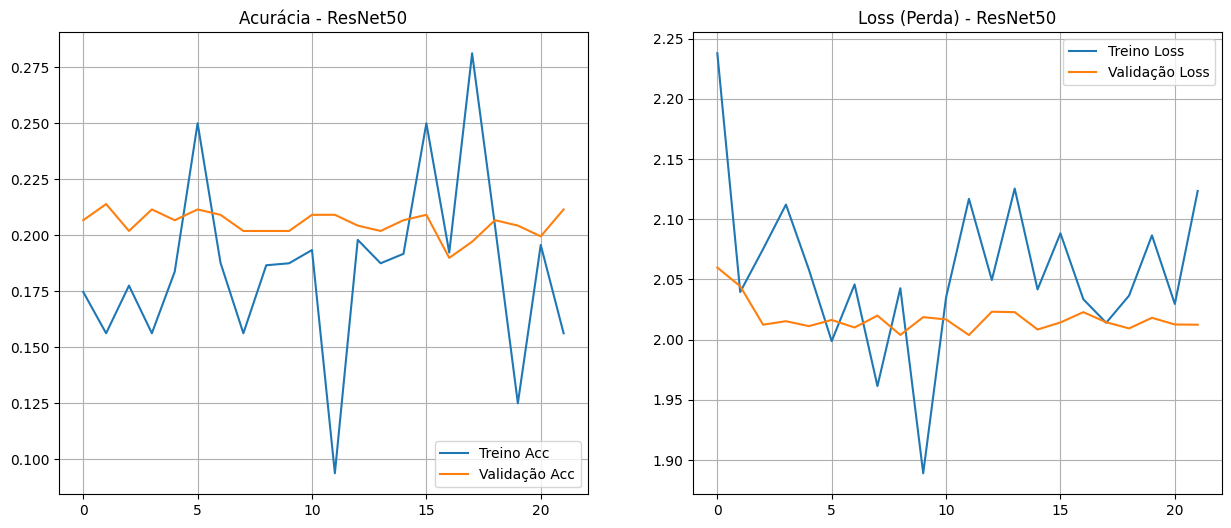

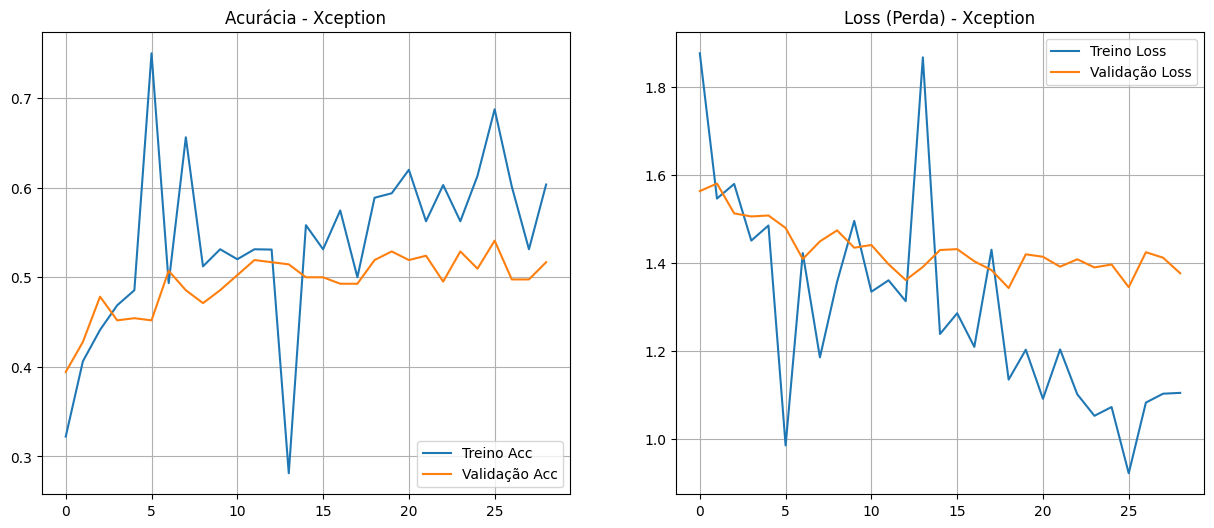

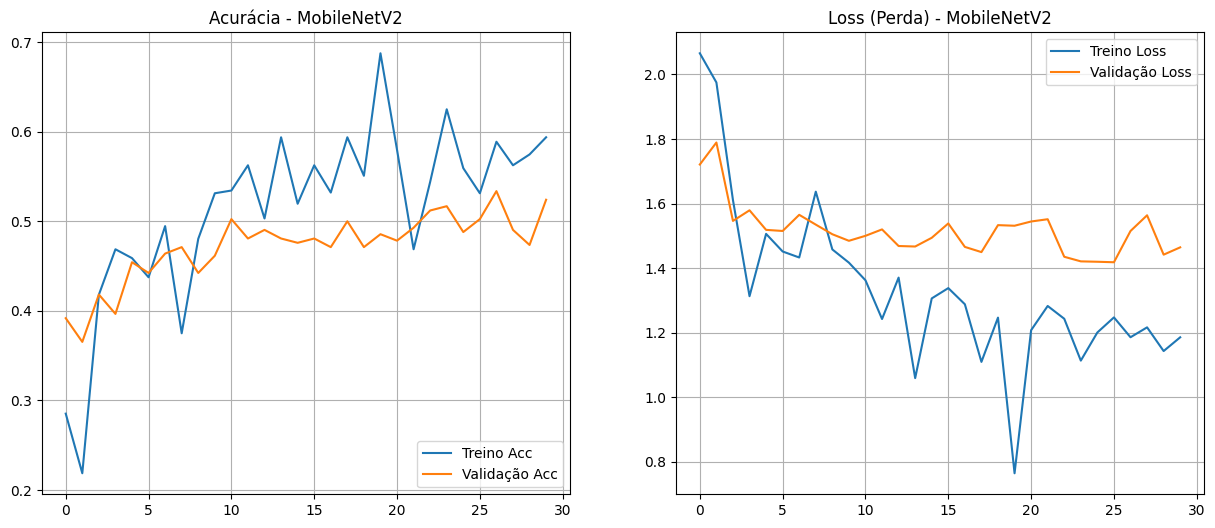

In [ ]:
# 7. Visualização dos Resultados
# Identifica qual variável de histórico está disponível
history_data = {}

if 'all_histories' in globals():
    print("✅ Detectado variável 'all_histories' (do seu código personalizado).")
    history_data = {name: h.history for name, h in all_histories.items()}
elif 'results' in globals():
    print("✅ Detectado variável 'results' (do código original).")
    history_data = {name: data['history'] for name, data in results.items()}
else:
    print("⚠️ Nenhuma variável de histórico encontrada (results ou all_histories).")
    print("Certifique-se de que o treinamento (Bloco 6) foi concluído nesta sessão.")

def plot_history(history_dict, model_name):
    acc = history_dict.get('accuracy', [])
    val_acc = history_dict.get('val_accuracy', [])
    loss = history_dict.get('loss', [])
    val_loss = history_dict.get('val_loss', [])

    if not acc:
        print(f"⚠️ Dados de histórico vazios para {model_name}")
        return

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 6))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Treino Acc')
    plt.plot(epochs_range, val_acc, label='Validação Acc')
    plt.legend(loc='lower right')
    plt.title(f'Acurácia - {model_name}')
    plt.grid(True)

    # Gráfico de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Treino Loss')
    plt.plot(epochs_range, val_loss, label='Validação Loss')
    plt.legend(loc='upper right')
    plt.title(f'Loss (Perda) - {model_name}')
    plt.grid(True)

    plt.show()

print("\n--- Gerando Gráficos de Performance ---")
if history_data:
    for name, h_dict in history_data.items():
        plot_history(h_dict, name)

Imagem selecionada para Grad-CAM: basal cell carcinoma/ISIC_0024432.jpg
Gerando Grad-CAM para DenseNet201


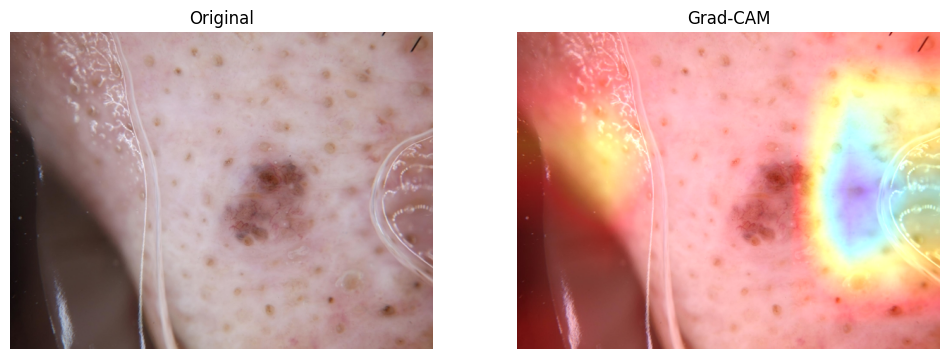

In [ ]:
# 8. Grad-CAM (Mapas de Calor)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 4 and 'conv' in layer.name:
            return layer.name
    return None

try:
    available_models = {}
    if 'all_models' in globals():
        available_models = all_models
    elif 'results' in globals():
        available_models = {k: v['model'] for k, v in results.items()}

    if not available_models:
        print("⚠️ Nenhum modelo treinado encontrado na memória.")
    else:
        # Busca automática de uma imagem válida para teste
        test_dir = os.path.join(DATA_DIR, 'Test')
        img_path = None

        if os.path.exists(test_dir):
            # Lista as pastas de classes
            subdirs = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
            if subdirs:
                # Tenta pegar 'Melanoma' se existir, senão pega a primeira classe disponível
                target_class = 'Melanoma' if 'Melanoma' in subdirs else subdirs[0]
                class_dir = os.path.join(test_dir, target_class)

                # Pega a primeira imagem desta classe
                images = os.listdir(class_dir)
                if images:
                    img_path = os.path.join(class_dir, images[0])
                    print(f"Imagem selecionada para Grad-CAM: {target_class}/{images[0]}")

        if img_path and os.path.exists(img_path):
            # Prepara a imagem
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            model_name = list(available_models.keys())[0]
            model = available_models[model_name]

            last_layer = None
            if 'DenseNet' in model.name: last_layer = 'conv5_block32_concat'
            elif 'ResNet' in model.name: last_layer = 'conv5_block3_out'
            elif 'Xception' in model.name: last_layer = 'block14_sepconv2_act'
            elif 'MobileNet' in model.name: last_layer = 'Out_relu'

            if not last_layer:
                last_layer = find_last_conv_layer(model)

            if last_layer:
                print(f"Gerando Grad-CAM para {model_name}")
                heatmap = make_gradcam_heatmap(img_array, model, last_layer)
                display_gradcam(img_path, heatmap)
            else:
                print(f"Não foi possível identificar a camada final para {model_name}.")
        else:
            print(f"Diretório de teste ou imagem não encontrados em: {test_dir}")
except Exception as e:
    print(f"Erro ao gerar Grad-CAM: {e}")


--- Gerando Matriz de Confusão para DenseNet201 ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 58s 10s/step


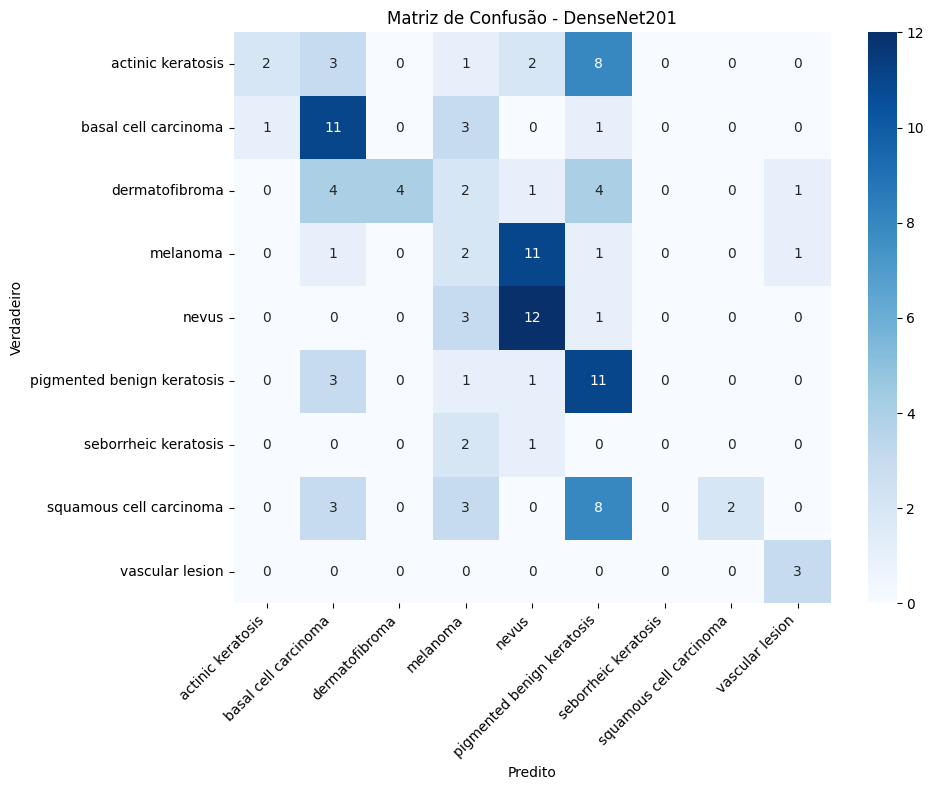


Relatório de Classificação - DenseNet201:
                            precision    recall  f1-score   support

         actinic keratosis       0.67      0.12      0.21        16
      basal cell carcinoma       0.44      0.69      0.54        16
            dermatofibroma       1.00      0.25      0.40        16
                  melanoma       0.12      0.12      0.12        16
                     nevus       0.43      0.75      0.55        16
pigmented benign keratosis       0.32      0.69      0.44        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       1.00      0.12      0.22        16
           vascular lesion       0.60      1.00      0.75         3

                  accuracy                           0.40       118
                 macro avg       0.51      0.42      0.36       118
              weighted avg       0.55      0.40      0.35       118


--- Gerando Matriz de Confusão para ResNet50 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


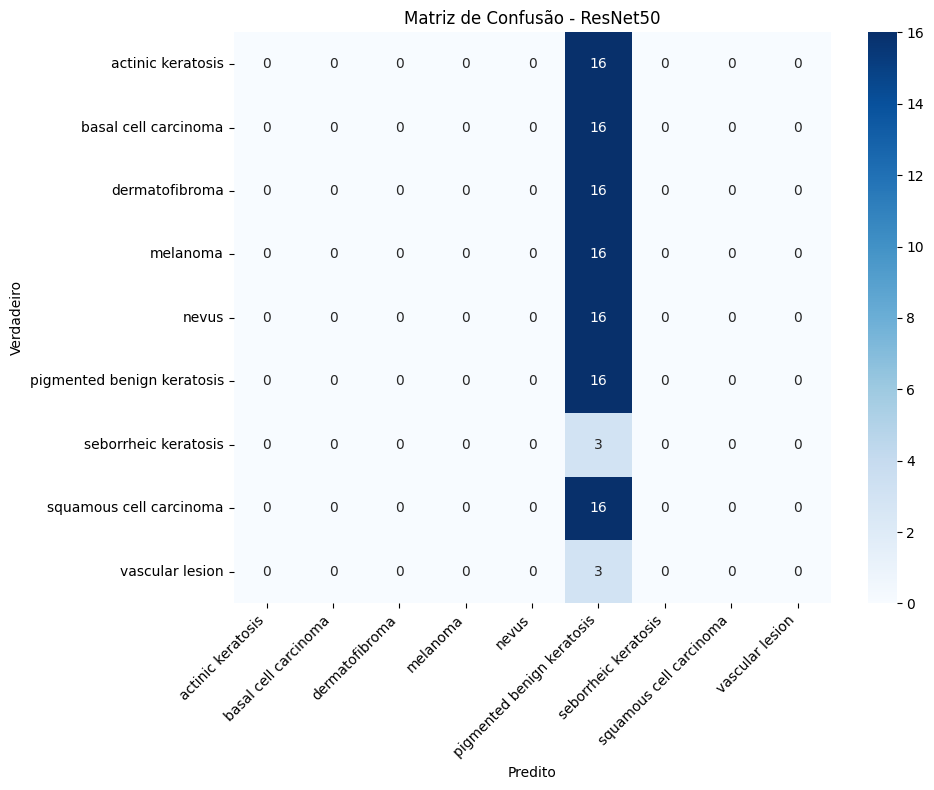


Relatório de Classificação - ResNet50:
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.00      0.00      0.00        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.00      0.00      0.00        16
                     nevus       0.00      0.00      0.00        16
pigmented benign keratosis       0.14      1.00      0.24        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.00      0.00      0.00         3

                  accuracy                           0.14       118
                 macro avg       0.02      0.11      0.03       118
              weighted avg       0.02      0.14      0.03       118


--- Gerando Matriz de Confusão para Xception ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


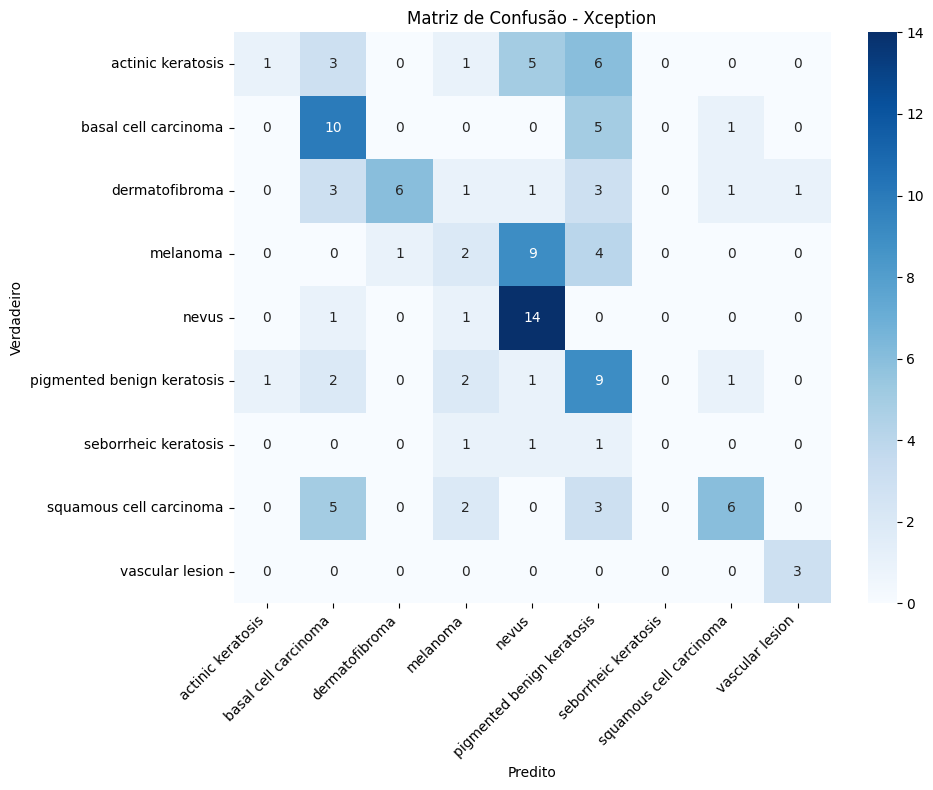


Relatório de Classificação - Xception:
                            precision    recall  f1-score   support

         actinic keratosis       0.50      0.06      0.11        16
      basal cell carcinoma       0.42      0.62      0.50        16
            dermatofibroma       0.86      0.38      0.52        16
                  melanoma       0.20      0.12      0.15        16
                     nevus       0.45      0.88      0.60        16
pigmented benign keratosis       0.29      0.56      0.38        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.67      0.38      0.48        16
           vascular lesion       0.75      1.00      0.86         3

                  accuracy                           0.43       118
                 macro avg       0.46      0.44      0.40       118
              weighted avg       0.48      0.43      0.39       118


--- Gerando Matriz de Confusão para MobileNetV2 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step


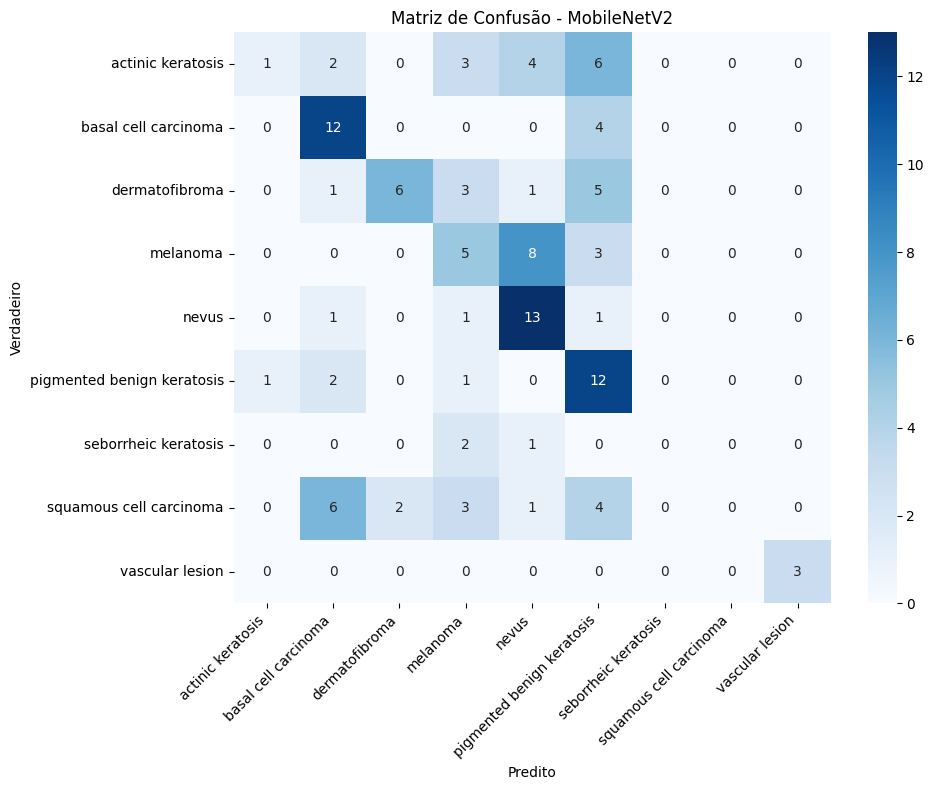


Relatório de Classificação - MobileNetV2:
                            precision    recall  f1-score   support

         actinic keratosis       0.50      0.06      0.11        16
      basal cell carcinoma       0.50      0.75      0.60        16
            dermatofibroma       0.75      0.38      0.50        16
                  melanoma       0.28      0.31      0.29        16
                     nevus       0.46      0.81      0.59        16
pigmented benign keratosis       0.34      0.75      0.47        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       1.00      1.00      1.00         3

                  accuracy                           0.44       118
                 macro avg       0.43      0.45      0.40       118
              weighted avg       0.41      0.44      0.37       118



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 9. Matriz de Confusão
def plot_confusion_matrix(model, generator, model_name):
    print(f"\n--- Gerando Matriz de Confusão para {model_name} ---")
    generator.reset()
    y_pred = model.predict(generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes
    class_names = list(generator.class_indices.keys())
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print(f"\nRelatório de Classificação - {model_name}:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

try:
    available_models = {}
    if 'all_models' in globals():
        available_models = all_models
    elif 'results' in globals():
        available_models = {k: v['model'] for k, v in results.items()}

    if available_models:
        for name, model in available_models.items():
            plot_confusion_matrix(model, test_generator, name)
    else:
        print("⚠️ Nenhum modelo disponível para gerar matriz de confusão.")
except Exception as e:
    print(f"Erro ao gerar Matriz de Confusão: {e}")


--- Iniciando Ensemble com 4 modelos ---
Gerando previsões para: DenseNet201...
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Gerando previsões para: ResNet50...
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Gerando previsões para: Xception...
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Gerando previsões para: MobileNetV2...
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step

🚀 Acurácia do Ensemble: 0.3898

Relatório de Classificação - ENSEMBLE:
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.52      0.81      0.63        16
            dermatofibroma       1.00      0.31      0.48        16
                  melanoma       0.14      0.12      0.13        16
                     nevus       0.38      0.69      0.49        16
pigmented benign keratosis       0.28      0.69      0.40        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       1.00      0.06

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


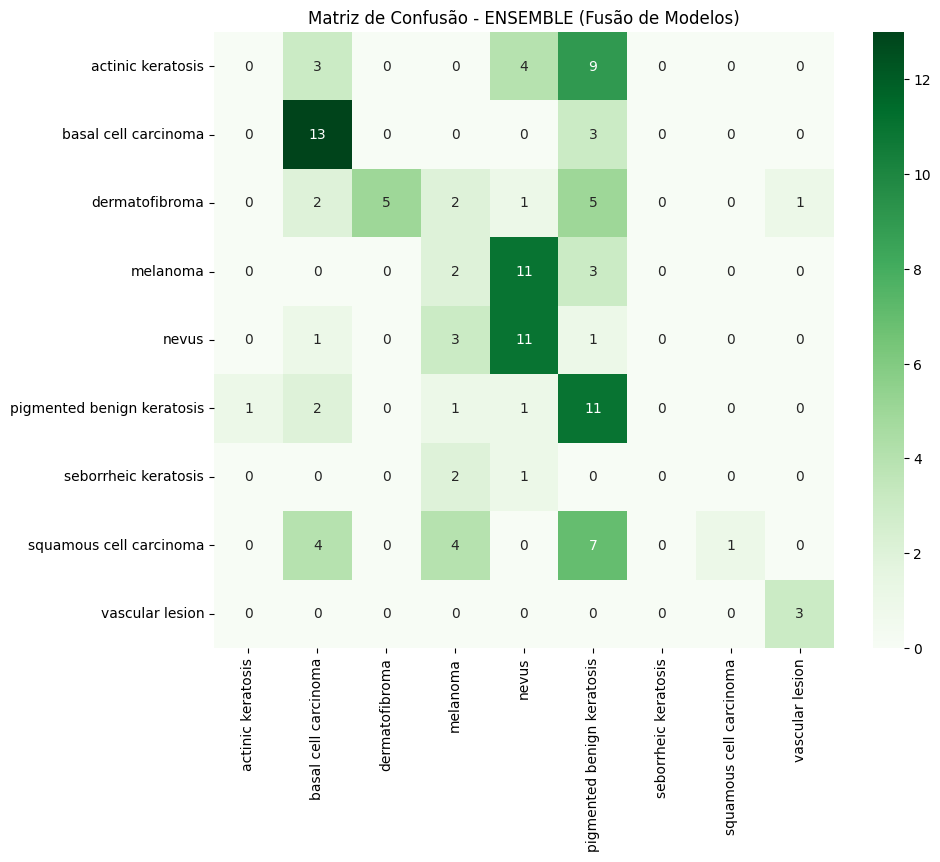

In [ ]:
# 10. Ensemble Learning (Melhoria Significativa)
# Combina as previsões dos melhores modelos para aumentar a precisão

def ensemble_predictions(models, generator):
    print(f"\n--- Iniciando Ensemble com {len(models)} modelos ---")

    # Lista para armazenar as probabilidades de cada modelo
    all_preds = []

    # Garante a ordem correta
    generator.reset()
    y_true = generator.classes

    for name, model in models.items():
        print(f"Gerando previsões para: {name}...")
        # Predição
        preds = model.predict(generator, verbose=1)
        all_preds.append(preds)

    # Soma as probabilidades (Soft Voting)
    summed_preds = np.sum(all_preds, axis=0)

    # Pega a classe com maior soma de probabilidades
    ensemble_pred_classes = np.argmax(summed_preds, axis=1)

    # Avaliação
    acc = np.mean(ensemble_pred_classes == y_true)
    print(f"\n🚀 Acurácia do Ensemble: {acc:.4f}")

    return ensemble_pred_classes

# Seleciona os modelos treinados
available_models = {}
if 'all_models' in globals():
    available_models = all_models
elif 'results' in globals():
    available_models = {k: v['model'] for k, v in results.items()}

if len(available_models) >= 2:
    ensemble_preds = ensemble_predictions(available_models, test_generator)

    # Matriz de Confusão do Ensemble
    print("\nRelatório de Classificação - ENSEMBLE:")
    print(classification_report(test_generator.classes, ensemble_preds, target_names=class_names))

    cm = confusion_matrix(test_generator.classes, ensemble_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão - ENSEMBLE (Fusão de Modelos)')
    plt.show()
else:
    print("⚠️ É necessário treinar pelo menos 2 modelos para fazer o Ensemble.")

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np
import gdown
import os

st.set_page_config(page_title="Detecção de Câncer de Pele", page_icon="🩺")

st.title("Detecção de Câncer de Pele 🩺")
st.write("Utilizando Inteligência Artificial para auxiliar no diagnóstico.")

# --- CONFIGURAÇÃO DO MODELO ---
MODEL_FILE = 'best_model_ResNet50.keras'

# COLOCA O TEU ID DO GOOGLE DRIVE AQUI DENTRO DAS ASPAS:
file_id = '1gaekLtSkAKR7eBh71y0Yrk0QafWKNX5_'

# URL de download direto do Google Drive
url = f'https://drive.google.com/uc?id={file_id}'

@st.cache_resource
def load_model_from_drive():
    # Se o arquivo não existir localmente, baixa do Drive
    if not os.path.exists(MODEL_FILE):
        gdown.download(url, MODEL_FILE, quiet=False)

    try:
        model = tf.keras.models.load_model(MODEL_FILE)
        return model
    except Exception as e:
        return None

with st.spinner('Baixando e carregando o modelo de IA... (Isso pode demorar um tiquinho)'):
    model = load_model_from_drive()

if model is None:
    st.error("Erro ao carregar o modelo! Verifique o ID do Google Drive.")
else:
    st.success("Modelo pronto para uso!")

# --- INTERFACE DE UPLOAD ---
uploaded_file = st.file_uploader("Escolha uma imagem...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Imagem enviada', use_column_width=True)

    st.write("Analisando...")

    # Pré-processamento
    img_array = np.array(image)
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]

    # Redimensiona para 176x176 (Tamanho do treino)
    img_array = tf.image.resize(img_array, [176, 176])
    img_array = tf.expand_dims(img_array, 0)

    if st.button("Classificar Lesão"):
        prediction = model.predict(img_array)
        classes = ['Benigno', 'Maligno']

        score = tf.nn.softmax(prediction[0])
        class_index = np.argmax(score)
        confidence = 100 * np.max(score)
        result_text = classes[class_index]

        st.write("---")
        if result_text == 'Maligno':
            st.error(f"### Resultado: {result_text}")
        else:
            st.success(f"### Resultado: {result_text}")

        st.write(f"Confiança da IA: **{confidence:.2f}%**")

Overwriting app.py


In [ ]:
%%writefile requirements.txt
streamlit
tensorflow
numpy
Pillow
gdown

Overwriting requirements.txt
